<h1>光頭傑夫製作</h1><img src="https://rolqiw.bl.files.1drv.com/y4mYqkObWmQmdJFd8pab8t8m7d_mFhh3_YG63fiAnPaG6gjahHFt0n087pF97x1W2wemm7hd4ZdiPD2OxoPtqcCD_4-Jy-fojnt97kGGWR4Hnq0-9Ny61afd7WVHVTmF_9pcr45OFDFSwLKByeQU1q9TjwKk-HsNmWVsW1eGQ4Gi-9G4pQ5DYoTxswYJ5r5dLF-kKsA1InEyrqmV3kF5pm4WQ?width=658&height=584&cropmode=none" width=160px align="left" />

### <span style="color:red ">以下是我們需要的量化分析套件:
---    
    1. Jupyter Notebook環境中，第一次安裝過就好，以後直接導入模組就好。
    2. 如果你是在Colab的環境中運作檔案，請每次安裝

! pip install backtrader

## <span style="color:red "> 先問一個問題，什麼是回測?
----
    投資股票，我相信每個人自有自己的一套看法，可能是看了股市資訊以後，做了一個決定，或是昨天做了一個夢，然後做一個決定。
    不管如何......
    這都是你投資的一個策略。
    策略表現的好壞，只能等你看買賣股票的結果。
    如果你財運很好，那真的很棒! 要不然這將是一場『非常貴』的實驗!!!
    
    回測是什麼?
    回測就是把你內心的投資策略，丟到過去的股價資料裡面，
    去模擬你準備操作這檔股票的動作，
    然後直接看你操作後，口袋還剩多少錢?來判定這個策略到底行不行?
    
    

## <span style="color:red "> 接下來，就讓我們Back trade一下吧!
---

## <span style="color:red ">  <策略1>先用SMA，來做個簡單的回測策略吧!
---
### 先回想一下，你還記的20-day SMA是什麼意思嗎?
    
    我們測定策略如下:
    1.如果今天的收盤價高於20-day SMA，那我們就買進一股的股票。
    2.如果今天的收盤價低於20-day SMA，那我們就賣掉一股的股票。
    3.任何時候，我們手上最多就一股股票。
    
    

### <span style="color:red "><策略1.1>導入需求模組

In [1]:
from datetime import datetime
import pandas as pd
import yfinance as yf
import backtrader as bt

### <span style="color:red "><策略1.2>建立交易策略

In [2]:
class SmaStrategy(bt.Strategy):
    #下面的20就是20 SMA的20天的意思
    params = (('ma_period', 19 ), )

    def __init__(self):
        # keep track of close price in the series
        self.data_close = self.datas[0].close

        # keep track of pending orders/buy price/buy commission
        self.order = None
        self.price = None
        self.comm = None

        # add a simple moving average indicator
        self.sma = bt.ind.SMA(self.datas[0], period=self.params.ma_period)

    def log(self, txt):
        '''Logging function'''
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f'{dt}, {txt}')

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # order already submitted/accepted - no action required
            return

        # report executed order
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'買單執行 --- 買價: {order.executed.price:.2f}, 成本: {order.executed.value:.2f}, 手續費: {order.executed.comm:.2f}')
                self.price = order.executed.price
                self.comm = order.executed.comm
            else:
                self.log(f'賣單執行 --- 賣價: {order.executed.price:.2f}, 成本: {order.executed.value:.2f}, 手續費: {order.executed.comm:.2f}')

        # report failed order
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('交易失敗')

        # set no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log(f'運作結果 --- 獲利狀況: {trade.pnl:.2f}, 淨獲利: {trade.pnlcomm:.2f}')

    def next(self):
        # do nothing if an order is pending
        if self.order:
            return

        # check if there is already a position
        if not self.position:
            # buy condition
            if self.data_close[0] > self.sma[0]:
                self.log(f'開出買單 --- 當時市場價格: {self.data_close[0]:.2f}')
                self.order = self.buy()
        else:
            # sell condition
            if self.data_close[0] < self.sma[0]:
                self.log(f'開出賣單 --- 當時市場價格: {self.data_close[0]:.2f}')
                self.order = self.sell()


### <span style="color:red "><策略1.3>抓取目標股票的歷史資料

In [3]:
data= yf.download(  '2330.tw',              #股票代碼
                    start='2022-3-28',      #資料開始日期
                    end='2023-3-28',         #資料結束日期
                    progress=False
                 )
data=bt.feeds.PandasData(dataname=pd.DataFrame({'open': data['Open'], 
                   'high': data['High'],
                   'low': data['Low'],
                   'close': data['Close'],
                   'volume': data['Volume'],
                  }))

### <span style="color:red "><策略1.4>建立回測分析「大腦」

In [4]:
#設立投資本金
#你可以根據你想要模擬的投資標的股價作適當調整
cash=1000

# create a Cerebro entity
cerebro = bt.Cerebro()

# set up the backtest
cerebro.adddata(data)
cerebro.addstrategy(SmaStrategy)
cerebro.broker.setcash(cash)




### <span style="color:red "><策略1.5>最興奮的時刻來了!-開始回測

In [5]:
# run backtest
print(f'起始資產總值: {cerebro.broker.getvalue():.2f}')
cerebro.run()
print(f'最終資產總值: {cerebro.broker.getvalue():.2f}')

起始資產總值: 1000.00
2022-05-18, 開出買單 --- 當時市場價格: 538.00
2022-05-19, 買單執行 --- 買價: 523.00, 成本: 523.00, 手續費: 0.00
2022-05-19, 開出賣單 --- 當時市場價格: 522.00
2022-05-20, 賣單執行 --- 賣價: 524.00, 成本: 523.00, 手續費: 0.00
2022-05-20, 運作結果 --- 獲利狀況: 1.00, 淨獲利: 1.00
2022-05-20, 開出買單 --- 當時市場價格: 530.00
2022-05-23, 買單執行 --- 買價: 533.00, 成本: 533.00, 手續費: 0.00
2022-05-24, 開出賣單 --- 當時市場價格: 520.00
2022-05-25, 賣單執行 --- 賣價: 522.00, 成本: 533.00, 手續費: 0.00
2022-05-25, 運作結果 --- 獲利狀況: -11.00, 淨獲利: -11.00
2022-05-27, 開出買單 --- 當時市場價格: 530.00
2022-05-30, 買單執行 --- 買價: 538.00, 成本: 538.00, 手續費: 0.00
2022-06-10, 開出賣單 --- 當時市場價格: 530.00
2022-06-13, 賣單執行 --- 賣價: 518.00, 成本: 538.00, 手續費: 0.00
2022-06-13, 運作結果 --- 獲利狀況: -20.00, 淨獲利: -20.00
2022-07-14, 開出買單 --- 當時市場價格: 475.00
2022-07-15, 買單執行 --- 買價: 481.00, 成本: 481.00, 手續費: 0.00
2022-08-10, 開出賣單 --- 當時市場價格: 500.00
2022-08-11, 賣單執行 --- 賣價: 513.00, 成本: 481.00, 手續費: 0.00
2022-08-11, 運作結果 --- 獲利狀況: 32.00, 淨獲利: 32.00
2022-08-11, 開出買單 --- 當時市場價格: 514.00
2022-08-12, 買單執行 --- 買價: 515.00, 成本: 5

### <span style="color:red "><策略1.6>畫張圖勝過千言萬語!-圖形化表達

<IPython.core.display.Javascript object>


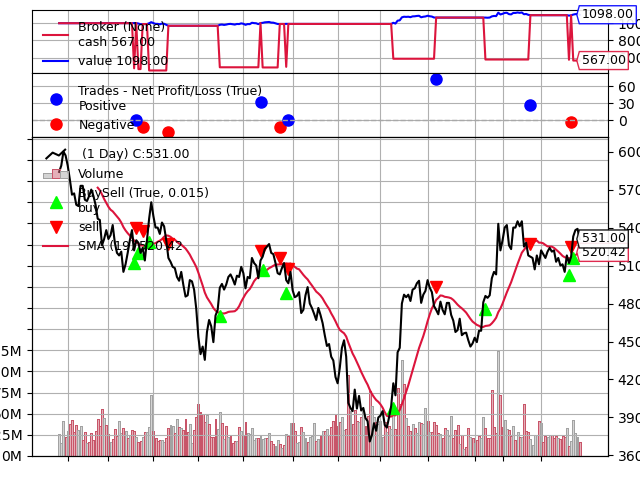

[[<Figure size 512x384 with 4 Axes>]]

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.dpi']=80
# plot results
cerebro.plot(iplot=True, volume=True)

In [ ]:
print(plt.style.available)

### <span style="color:red ">如果你有跑不出圖的問題

In [ ]:
#如果你有跑不出圖的問題
!pip uninstall matplotlib  

In [ ]:
!pip install matplotlib==3.2.2

### <span style="color:red "><策略2>我們不得不懷疑20-day SMA是一個好選擇嗎?
--------
    你有想過一個問題?幾日均線說穿了都是人說的一個故事。那既然是人定的，為何不讓機器來告訴我，屬於台積電的財富均線應該是幾日比較好呢?

### <span style="color:red "><策略2.2>建立交易策略

In [16]:
class SmaStrategy(bt.Strategy):
    params = (('ma_period', 20),)

    def __init__(self):
        # keep track of close price in the series
        self.data_close = self.datas[0].close

        # keep track of pending orders
        self.order = None

        # add a simple moving average indicator
        self.sma = bt.ind.SMA(self.datas[0], period=self.params.ma_period)

    def log(self, txt):
        '''Logging function'''
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f'{dt}, {txt}')

    def notify_order(self, order):
        # set no pending order
        self.order = None

    def next(self):
        # do nothing if an order is pending
        if self.order:
            return

        # check if there is already a position
        if not self.position:
            # buy condition
            if self.data_close[0] > self.sma[0]:
                self.order = self.buy()
        else:
            # sell condition
            if self.data_close[0] < self.sma[0]:
                self.order = self.sell()

    def stop(self):
        self.log(f'(SMA週期設定 = {self.params.ma_period:2d}) --- 淨利數值: {self.broker.getvalue()-cash:.2f}')


### <span style="color:red "><策略2.4>建立回測分析「大腦」

In [17]:
#設立投資本金
#你可以根據你想要模擬的投資標的股價作適當調整
cash=1000

# create a Cerebro entity
cerebro = bt.Cerebro()
cerebro.optstrategy(SmaStrategy, ma_period=range(5, 61))
cerebro.adddata(data)
cerebro.broker.setcash(cash)



### <span style="color:red "><策略2.5>最興奮的時刻來了!-開始回測

In [18]:
# win系統下，請固定用單核去跑。其他系統可以試試看多核
cerebro.run(maxcpus=1)


2023-03-27, (SMA週期設定 =  5) --- 淨利數值: -78.00
2023-03-27, (SMA週期設定 =  6) --- 淨利數值: -7.50
2023-03-27, (SMA週期設定 =  7) --- 淨利數值: 11.00
2023-03-27, (SMA週期設定 =  8) --- 淨利數值: -21.00
2023-03-27, (SMA週期設定 =  9) --- 淨利數值: 26.50
2023-03-27, (SMA週期設定 = 10) --- 淨利數值: 30.00
2023-03-27, (SMA週期設定 = 11) --- 淨利數值: 48.00
2023-03-27, (SMA週期設定 = 12) --- 淨利數值: 79.00
2023-03-27, (SMA週期設定 = 13) --- 淨利數值: 93.00
2023-03-27, (SMA週期設定 = 14) --- 淨利數值: 93.00
2023-03-27, (SMA週期設定 = 15) --- 淨利數值: 82.50
2023-03-27, (SMA週期設定 = 16) --- 淨利數值: 69.50
2023-03-27, (SMA週期設定 = 17) --- 淨利數值: 87.50
2023-03-27, (SMA週期設定 = 18) --- 淨利數值: 93.50
2023-03-27, (SMA週期設定 = 19) --- 淨利數值: 98.00
2023-03-27, (SMA週期設定 = 20) --- 淨利數值: 106.00
2023-03-27, (SMA週期設定 = 21) --- 淨利數值: 94.50
2023-03-27, (SMA週期設定 = 22) --- 淨利數值: 96.00
2023-03-27, (SMA週期設定 = 23) --- 淨利數值: 97.00
2023-03-27, (SMA週期設定 = 24) --- 淨利數值: 79.50
2023-03-27, (SMA週期設定 = 25) --- 淨利數值: 54.50
2023-03-27, (SMA週期設定 = 26) --- 淨利數值: 71.50
2023-03-27, (SMA週期設定 = 27) --- 淨利數值: 40.50
2023-03-

[[<backtrader.cerebro.OptReturn at 0x1b199b6a2b0>],

### <span style="color:red "><策略3>技術分析不是一直說什麼黃金交叉...什麼死亡交叉...
-----
    1.黃金交叉：短天期均線向上與長天期交叉，稱為黃金交叉。
    2.死亡交叉：短天期均線向下與長天期交叉，稱為死亡交叉。

### <span style="color:red "><策略3.2>建立交易策略

In [24]:
class SmaCross(bt.Strategy):
    params = dict(
        pfast=5,   # 短期均線週期
        pslow=20   # 長期均線週期
    )

    def __init__(self):
        self.data_close = self.datas[0].close
        
        self.order = None
        self.price = None
        self.comm = None

        
        sma1 = bt.ind.SMA(self.datas[0],period=self.p.pfast)  # 短期均線
        sma2 = bt.ind.SMA(self.datas[0],period=self.p.pslow)  # 長期均線
        self.crossover = bt.ind.CrossOver(sma1, sma2)

    def log(self, txt):
        '''Logging function'''
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f'{dt}, {txt}')

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # order already submitted/accepted - no action required
            return

        # report executed order
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'買單執行 --- 買價: {order.executed.price:.2f}, 成本: {order.executed.value:.2f}, 手續費: {order.executed.comm:.2f}')
                self.price = order.executed.price
                self.comm = order.executed.comm
            else:
                self.log(f'賣單執行 --- 賣價: {order.executed.price:.2f}, 成本: {order.executed.value:.2f}, 手續費: {order.executed.comm:.2f}')

        # report failed order
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('交易失敗')

        # set no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log(f'運作結果 --- 獲利狀況: {trade.pnl:.2f}, 淨獲利: {trade.pnlcomm:.2f}')

    def next(self):
        # do nothing if an order is pending
        if self.order:
            return

        # check if there is already a position
        if not self.position:
            # buy condition
            if self.crossover > 0:
                self.log(f'開出買單 --- 當時市場價格: {self.data_close[0]:.2f}')
                self.order = self.buy()
        else:
            # sell condition
            if self.crossover < 0:
                self.log(f'開出賣單 --- 當時市場價格: {self.data_close[0]:.2f}')
                self.order = self.sell()
    def stop(self):
        self.log(f'(SMA週期設定 = 短週期:{self.p.pfast:2d},長週期:{self.p.pslow:2d}) --- 最終資產價值: {self.broker.getvalue():.2f}')

### <span style="color:red "><策略3.4>建立回測分析「大腦」

In [25]:
#設立投資本金
#你可以根據你想要模擬的投資標的股價作適當調整
cash=1000

cerebro = bt.Cerebro()
# set up the backtest
cerebro.adddata(data)
cerebro.addstrategy(SmaCross)
cerebro.broker.setcash(cash)



### <span style="color:red "><策略3.5>最興奮的時刻來了!-開始回測

In [26]:
# run backtest
print(f'起始資產總值: {cerebro.broker.getvalue():.2f}')
cerebro.run()

起始資產總值: 1000.00
2022-05-23, 開出買單 --- 當時市場價格: 528.00
2022-05-24, 買單執行 --- 買價: 530.00, 成本: 530.00, 手續費: 0.00
2022-05-25, 開出賣單 --- 當時市場價格: 524.00
2022-05-26, 賣單執行 --- 賣價: 523.00, 成本: 530.00, 手續費: 0.00
2022-05-26, 運作結果 --- 獲利狀況: -7.00, 淨獲利: -7.00
2022-05-30, 開出買單 --- 當時市場價格: 547.00
2022-05-31, 買單執行 --- 買價: 542.00, 成本: 542.00, 手續費: 0.00
2022-06-14, 開出賣單 --- 當時市場價格: 513.00
2022-06-15, 賣單執行 --- 賣價: 508.00, 成本: 542.00, 手續費: 0.00
2022-06-15, 運作結果 --- 獲利狀況: -34.00, 淨獲利: -34.00
2022-07-18, 開出買單 --- 當時市場價格: 495.50
2022-07-19, 買單執行 --- 買價: 487.50, 成本: 487.50, 手續費: 0.00
2022-08-25, 開出賣單 --- 當時市場價格: 508.00
2022-08-26, 賣單執行 --- 賣價: 513.00, 成本: 487.50, 手續費: 0.00
2022-08-26, 運作結果 --- 獲利狀況: 25.50, 淨獲利: 25.50
2022-11-09, 開出買單 --- 當時市場價格: 417.00
2022-11-10, 買單執行 --- 買價: 409.00, 成本: 409.00, 手續費: 0.00
2022-12-08, 開出賣單 --- 當時市場價格: 471.50
2022-12-09, 賣單執行 --- 賣價: 478.00, 成本: 409.00, 手續費: 0.00
2022-12-09, 運作結果 --- 獲利狀況: 69.00, 淨獲利: 69.00
2023-01-10, 開出買單 --- 當時市場價格: 486.00
2023-01-11, 買單執行 --- 買價: 487.00, 成本: 4

### <span style="color:red "><策略3.6>畫張圖勝過千言萬語!-圖形化表達

<IPython.core.display.Javascript object>


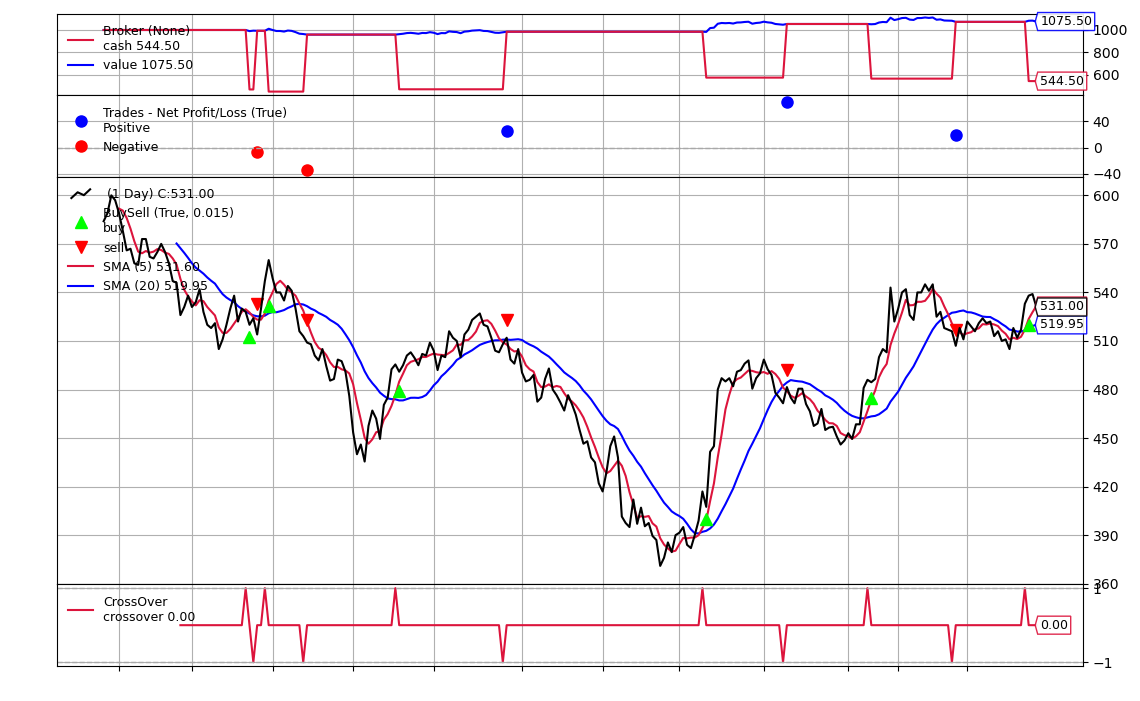

[[<Figure size 512x384 with 4 Axes>]]

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

# plot results
cerebro.plot(iplot=True, volume=False)

### <span style="color:red "><策略4>上面是5日線和10日線的交叉結果，那如果我想要知道哪兩條線的配對交叉結果最好...
-----
###     我就是想知道:
        到底是MA5穿過MA20比較厲害?
        還是MA20穿出MA60比較厲害?

### <span style="color:red "><策略4.2>建立交易策略

In [29]:
class SmaCross(bt.Strategy):
    params = dict(
        pfast=5,   # 短期均線週期
        pslow=10   # 長期均線週期
    )

    def __init__(self):
        self.data_close = self.datas[0].close
        
        self.order = None
        self.price = None
        self.comm = None

        
        sma1 = bt.ind.SMA(self.datas[0],period=self.p.pfast)  # 短期均線
        sma2 = bt.ind.SMA(self.datas[0],period=self.p.pslow)  # 長期均線
        self.crossover = bt.ind.CrossOver(sma1, sma2)

    def log(self, txt):
        '''Logging function'''
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f'{dt}, {txt}')

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # order already submitted/accepted - no action required
            return

        # report executed order
        if order.status in [order.Completed]:
            if order.isbuy():
                self.price = order.executed.price
                self.comm = order.executed.comm

        # set no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return


    def next(self):
        # do nothing if an order is pending
        if self.order:
            return

        # check if there is already a position
        if not self.position:
            # buy condition
            if self.crossover > 0:
                self.order = self.buy()
        else:
            # sell condition
            if self.crossover < 0:
                self.order = self.sell()
    def stop(self):
        self.log(f'(SMA週期設定 = 短週期:{self.p.pfast:2d},長週期:{self.p.pslow:2d}) --- 最終資產價值: {self.broker.getvalue()-cash:.2f}')

### <span style="color:red "><策略4.4>建立回測分析「大腦」

In [32]:
#設立投資本金
#你可以根據你想要模擬的投資標的股價作適當調整
cash=1000

cerebro = bt.Cerebro()
cerebro.optstrategy(SmaCross, pfast=[5,7],pslow=[11,12,13,14,15,16,17,18,19,20,21,22])
cerebro.adddata(data)
cerebro.broker.setcash(cash)



In [30]:
#設立投資本金
#你可以根據你想要模擬的投資標的股價作適當調整
cash=1000

cerebro = bt.Cerebro()
cerebro.optstrategy(SmaCross, pfast=range(5,21),pslow=range(21,51))
cerebro.adddata(data)
cerebro.broker.setcash(cash)



### <span style="color:red "><策略4.5>最興奮的時刻來了!-開始回測

In [33]:
# win系統下，請固定用單核去跑。其他系統可以試試看多核
cerebro.run(maxcpus=1)


2023-03-27, (SMA週期設定 = 短週期: 5,長週期:11) --- 最終資產價值: 141.50
2023-03-27, (SMA週期設定 = 短週期: 5,長週期:12) --- 最終資產價值: 129.50
2023-03-27, (SMA週期設定 = 短週期: 5,長週期:13) --- 最終資產價值: 103.50
2023-03-27, (SMA週期設定 = 短週期: 5,長週期:14) --- 最終資產價值: 81.50
2023-03-27, (SMA週期設定 = 短週期: 5,長週期:15) --- 最終資產價值: 86.50
2023-03-27, (SMA週期設定 = 短週期: 5,長週期:16) --- 最終資產價值: 78.00
2023-03-27, (SMA週期設定 = 短週期: 5,長週期:17) --- 最終資產價值: 70.00
2023-03-27, (SMA週期設定 = 短週期: 5,長週期:18) --- 最終資產價值: 72.50
2023-03-27, (SMA週期設定 = 短週期: 5,長週期:19) --- 最終資產價值: 83.50
2023-03-27, (SMA週期設定 = 短週期: 5,長週期:20) --- 最終資產價值: 75.50
2023-03-27, (SMA週期設定 = 短週期: 5,長週期:21) --- 最終資產價值: 81.00
2023-03-27, (SMA週期設定 = 短週期: 5,長週期:22) --- 最終資產價值: 77.50
2023-03-27, (SMA週期設定 = 短週期: 7,長週期:11) --- 最終資產價值: 89.00
2023-03-27, (SMA週期設定 = 短週期: 7,長週期:12) --- 最終資產價值: 80.50
2023-03-27, (SMA週期設定 = 短週期: 7,長週期:13) --- 最終資產價值: 88.50
2023-03-27, (SMA週期設定 = 短週期: 7,長週期:14) --- 最終資產價值: 91.50
2023-03-27, (SMA週期設定 = 短週期: 7,長週期:15) --- 最終資產價值: 93.00
2023-03-27, (SMA週期設定 = 短週期: 7,長週期:16) --- 最終資

[[<backtrader.cerebro.OptReturn at 0x1b19a7346a0>],